# Exercise 4 - Tree based machine learning


### By Dominik Geng and Joshua Zielinski 

## Preliminaries

In [1]:
# import modules
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# base classes

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

## Density Tree

In [3]:
class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()
        
    def train(self, data, prior, n_min=20):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D)) # number of features to consider for each split decision

        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = np.min(data, axis=0), np.max(data, axis=0)
        self.box = m.copy(), M.copy()
        
        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features   = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1

        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                 # your code here
                feature_indices = np.random.permutation(valid_features)[0:D_try]
                left,right = make_density_split_node(node,N,feature_indices)
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                make_density_leaf_node(node, N)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise
        m,M = self.box
        p_x_given_y = leaf.response
        indicator = np.where(((M-x) >= 0) * ((x-m) >= 0),1,0).prod()
        return indicator * p_x_given_y * self.prior

In [4]:
def get_new_boxes(m,M,t,j):
    m_l = m.copy()
    M_l = np.where(np.arange(len(m)) == j, t,M.copy())
    m_r = np.where(np.arange(len(m)) == j, t,m.copy())
    M_r = M.copy()
    
    return (m_l,M_l),(m_r,M_r)
    
def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    m, M = node.box

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
    V = np.prod(M-m)
    
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 
        # 'np.unique()'. Describe here why this is necessary.
        data_unique = np.unique((node.data[:, j]))
    #this was necessary to sort the data in order to place a candidate threshold in the midde of all gaps.
    #
        # Compute candidate thresholds
        tj = (data_unique[:-1]+data_unique[1:]) / 2
                                
        
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            # Compute the error
                                
            N_l = len(np.where(data_unique < t))                     
            
                                
           
            
                                   
            V_l = V * (tj-m[j])/(M[j]-m[j])
            V_r = V * (M[j]-tj)/(M[j]-m[j])
        
            N_l = np.less(node.data[:,j],tj.reshape(-1,1)).sum(axis = 1)
            N_r = n - N_l
        
            loo_error = N_l / (N*V_l) *(N_l / N - 2*(N_l-1)/(N-1)) + N_r / (N*V_r) *(N_r / N - 2*(N_r-1)/(N-1))
            # choose the best threshold that
                                
            if len(loo_error) == 0: continue
            i= np.argmin(loo_error)
            loo_error = min(loo_error)                   
                                   
            if loo_error < e_min:
                e_min = loo_error
                j_min = j
                t_min = tj[i]

    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] < t_min].copy()
    right.data = node.data[node.data[:,j_min] > t_min].copy()
    left.box,right.box = get_new_boxes(m,M,t_min,j_min)

                                   
                      
                                   
                                   
    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [5]:
def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    n = node.data.shape[0]
    v = np.prod(node.box[1]-node.box[0])
    node.response = n / (N*v)

## Decision Tree

In [6]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                
                
                #we do this, to avoid, the case that there are only instances with the same value in each of the selected features
                mask = np.array([len(np.unique(node.data[:,c])) != 1 for c in range(node.data.shape[1])])
                good_features = np.arange(node.data.shape[1])[mask]
                feature_indices = np.random.permutation(good_features)[0:D_try]
                    
                left,right = make_decision_split_node(node,feature_indices)
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_decision_leaf_node(node)
                
    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return leaf.response

In [7]:
def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
        
    for j in feature_indices:
        data_unique = np.unique(node.data[:, j])

        # Compute candidate thresholds
        tj = (data_unique[:-1]+data_unique[1:]) / 2
        
        N_l = np.less(node.data[:,j],tj.reshape(-1,1)).sum(axis = 1)
        N_r = n - N_l
    
    for t in tj:
            N_l = np.where(node.data[:, j] < t,True,False).sum() 
            N_r = np.where(node.data[:, j] > t,True,False).sum()
         
            gini_left = N_l* (1-((np.unique(node.labels[node.data[:,j] < t], return_counts=True)[1])**2 / N_l**2).sum())
            gini_right  = N_r * (1-((np.unique(node.labels[node.data[:,j] > t], return_counts=True)[1])**2 / N_r**2).sum())
            gini = gini_left+gini_right

            # choose the best threshold that
            if gini < e_min:
                    e_min = gini
                    j_min = j
                    t_min = t

    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] < t_min] # data in left node
    left.labels = node.labels[node.data[:,j_min] < t_min] # corresponding labels
    right.data = node.data[node.data[:,j_min] > t_min]
    right.labels = node.labels[node.data[:,j_min] > t_min]

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right    

In [8]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = len(node.labels)
    dist = np.zeros(10)
    uniques,counts = np.unique(node.labels, return_counts=True)
    dist[uniques] = counts
    dist /= node.N
    node.response = dist

In [9]:
def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    return len(np.unique(node.labels)) == 1

## Evaluation of Density and Decision Tree

In [10]:
# read and prepare the digits data
from sklearn.datasets import load_digits

loader = load_digits()

data= loader["data"]
targets = loader["target"]
target_names = loader["target_names"]

In [11]:
# train trees, plot training error confusion matrices, and comment on your results
decision_tree = DecisionTree()
decision_tree.train(data, targets,n_min = 10)

In [12]:
#Trainig of the Density trees
C = len(target_names)
density_trees = []
for K in range(C):
    tree = DensityTree()
    prior = (targets == K).sum() / len(targets)
    tree.train(data[targets == K], prior, n_min=10)
    density_trees.append(tree)

In [13]:
def get_prediction(data,decision_tree,density_trees):
    posterior_decision = np.zeros([len(data),10])
    posterior_density = np.zeros([len(data),10])

    for i in range(len(data)):
        posterior_decision[i] = decision_tree.predict(data[i])
        posterior_density[i] = np.array([t.predict(data[i]) for t in density_trees])
    
    prediction_density = np.argmax(posterior_density,axis = 1)
    prediction_decision = np.argmax(posterior_decision,axis = 1)
    return prediction_density,prediction_decision

In [14]:
def draw_conv_mat(predictions,target = targets,titles = ["density","decision"]):
    plt.figure(figsize = (10,30))
    n = len(predictions)
    
    for i in range(0,len(predictions)):
        plt.subplot(1,2,i+1)
        plt.title("confusion matrix for "+titles[i]+" tree",fontsize = 15)
        decision_conv = np.zeros((10,10))
        points = np.concatenate((predictions[i].reshape(-1,1),targets.reshape(-1,1)),axis = 1)
        points,counts = np.unique(points,return_counts = True,axis = 0)
        decision_conv[points[:,0],points[:,1]] = counts

        plt.xlabel("target",fontsize = 15)
        plt.ylabel("prediction",fontsize = 15)

        plt.xticks([0,1,2,3,4,5,6,7,8,9],fontsize = 15)
        plt.yticks([0,1,2,3,4,5,6,7,8,9],fontsize = 15)
        plt.imshow(decision_conv)

In [15]:
#evaluate the trees
prediction_density_tree,prediction_decision_tree = get_prediction(data,decision_tree,density_trees)

#get the rates of correct predictions
rate_decision = (prediction_decision_tree == targets).sum() / len(targets)
rate_density = (prediction_density_tree == targets).sum() / len(targets)

In [17]:
print(f"rate of correct predictions of the decision tree: {round(rate_decision,4)*100}%")
print(f"rate of correct predictions of the density tree: {round(rate_density,4)*100}%")

rate of correct predictions of the decision tree: 81.58%
rate of correct predictions of the density tree: 78.69%


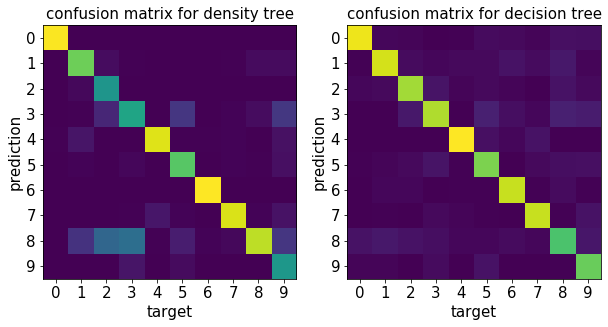

In [18]:
#visualize the confusion matrix
draw_conv_mat([prediction_density_tree,prediction_decision_tree])

We see, that the two different trees have a different performance. The density tree has some problems to correctly classify the 2s and 9s, whereas the decision tree has almost no problem to predict any label correct. We observe, that for both trees, there is a relativelyy high propability to predict the 1,2, and 3 as an 8, but this behaviour is much more visible for the decision tree. <br> Why do we observe such a behaviour? Lets first look at the density trees. The density trees try to determine, how probable a set of features is given a certain digit. Therefore it can happen, that that the two trees trained in different digits can give high densities for the other digit in case the two digits look very similar (e.g. if we have a 3 and almost close it on the left side, it looks similar to a 8, so it can reach a high density in the tree trained on the 8. This can be one explanation for the high rate of 3 falsely classified as 8). This behaviour is supported by the fact, that the prediction using a density tree uses 10 different trees, which predict their density independently from each other. The decision tree is a single tree, handling all different classes. Therefore it can more easily seperate (at least on the training data) the classes until it has a pure leaf. This helps to avoid high posteriors for two differnt classes as observed with the density tree.

## Density and Decision Forest

In [19]:
class DensityForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DensityTree() for i in range(n_trees)]
    
    def train(self, data, prior, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            indices = np.random.choice(np.arange(len(data)),len(data),replace = True)
            tree.train(data[indices],prior,n_min)

    def predict(self, x):
        # compute the ensemble prediction
        return np.array([tree.predict(x) for tree in self.trees]).mean()



In [20]:
class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]
    
    def train(self, data, labels, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            indices = np.random.choice(np.arange(len(data)),len(data),replace = True)
            tree.train(data[indices],labels[indices],n_min)
            

    def predict(self, x):
        # compute the ensemble prediction
        posteriors = np.zeros(10)
        for tree in self.trees:
            posteriors += tree.predict(x)
        return posteriors / len(self.trees)

## Evaluation of Density and Decision Forest

In [21]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
n_trees = 20

#Trainig of the density forests
C = len(target_names)
density_forrests = []
for K in range(C):
    forrest = DensityForest(n_trees = 20)
    prior = (targets == K).sum() / len(targets)
    forrest.train(data[targets == K], prior, n_min=15)
    density_forrests.append(forrest)

In [22]:
#Training of decision forest
decision_forest = DecisionForest(n_trees = 20)
decision_forest.train(data, targets,n_min = 0)

In [23]:
#evaluate the forests
print(len(density_forrests))
prediction_density,prediction_decision = get_prediction(data,decision_forest,density_forrests)

#get the rates of correct predictions
rate_decision = (prediction_decision == targets).sum() / len(targets)
rate_density = (prediction_density == targets).sum() / len(targets)

10


In [24]:
print(f"rate of correct predictions of the decision forrest: {round(rate_decision,4)*100}%")
print(f"rate of correct predictions of the density forrests: {round(rate_density,4)*100}%")

rate of correct predictions of the decision forrest: 100.0%
rate of correct predictions of the density forrests: 89.71000000000001%


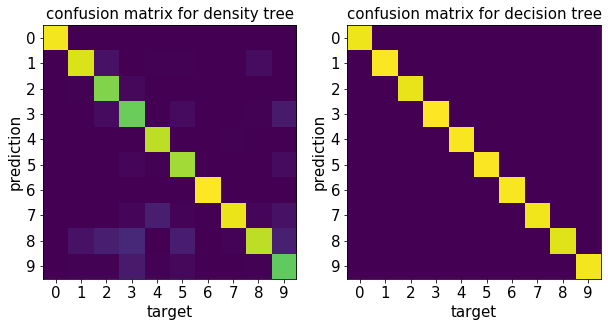

In [25]:
#visualize the confusion matrix
draw_conv_mat([prediction_density,prediction_decision])

In [26]:
from sklearn.ensemble import RandomForestClassifier as skl_clf


In [27]:
clf = skl_clf(n_estimators = n_trees)
clf.fit(data,targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
pred = clf.predict(data)
rate_sklearn = (pred == targets).sum() / len(targets)

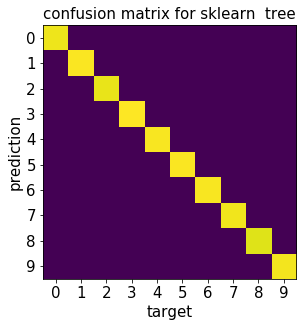

In [29]:
draw_conv_mat([pred],titles = ["sklearn "])




In [30]:
print(f"rate of correct predictions of the sklaern random forest classifier: {round(rate_sklearn,4)*100}%")

rate of correct predictions of the sklaern random forest classifier: 100.0%


For the decision forest, we now observe a rate of correct classifications of 100%. Therefore, we observe no entries in the confusion matrix outside the diagonal elements. Compared to the results from the single tree, this is a huge improvement. For the density tree, we also observe an improvement. The rate of correct predictions increased about 5% and therefore the number of off diagonal elements in the confusion matrix decreased. Nevertheless, we observe, that the general problem of the density tree remained: Similiar misclassifications occured as before (e.g. 2s were predicted as 8s, 9s were predicted as 8s). In this experiment, we chose the minimal number of instances per leaf 0. Therefore each of the decision tree in the decision forest would reach a perfect classification rate on the training data. The built-in decision forest of the scikit-learn library reached a perfect prediction rate on the date. But we have to be aware of the fact, that for this example, the test data were not independent from the training data.